In [1]:
import numpy as np
import tensorflow as tf
import mdn

In [3]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Attention
from tensorflow.keras.layers import (Conv2D, Input, Reshape, 
                                     Lambda, Dense, Conv2DTranspose)

if tf.test.is_gpu_available():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import matplotlib.pyplot as plt
import os
import utils

from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                       TensorBoard, Callback)
import datetime
from time import time
from utils import TrainTimeCallback

In [5]:
import matplotlib.pyplot as plt

In [6]:
seq_len = 128
act_len = 3
n_mixtures = 5
output_dims = 32

In [7]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          64384        3938       46649         269       13796       59522
Swap:          2047           0        2047


In [8]:
num_instances = len(os.listdir('./data/states'))

In [9]:
def load_folder(path):
    files = os.listdir(path)
    _1 = np.load(os.path.join(path, files[0]))
    data = np.zeros((len(files), *_1.shape))
    for i, fname in enumerate(files):
        data[i] = np.load(os.path.join(path, fname))
    return data

In [10]:
z_states = load_folder('./data/z_states')

In [11]:
z_states.shape

(154624, 32)

In [12]:
actions = load_folder('./data/actions')

In [13]:
actions.shape

(154624, 3)

In [14]:
154624 / 128 / 128

9.4375

In [15]:
pair = np.concatenate((z_states, actions), axis=1)

In [16]:
pair.shape

(154624, 35)

In [17]:
latent_dataset = tf.data.Dataset.from_tensor_slices(pair)

In [18]:
sequences = latent_dataset.batch(seq_len + 1, drop_remainder=True)

In [19]:
sequences

<BatchDataset shapes: (129, 35), types: tf.float64>

In [20]:
def split_input_target(chunk):
    input_z = chunk[:-1]
    target_z = chunk[1:, :32]
    return input_z, target_z

In [21]:
dataset = sequences.map(split_input_target)

In [22]:
dataset

<MapDataset shapes: ((128, 35), (128, 32)), types: (tf.float64, tf.float64)>

In [23]:
dataset = dataset.shuffle(10000).batch(utils.BATCH_SIZE, drop_remainder=True)

In [24]:
dataset

<BatchDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [26]:
i = 0
for a, b in dataset:
    i += 1

In [27]:
i

9

In [28]:
percent_20 = i // 5
val = dataset.take(percent_20)
train = dataset.skip(percent_20)

In [29]:
val

<TakeDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [30]:
train

<SkipDataset shapes: ((128, 128, 35), (128, 128, 32)), types: (tf.float64, tf.float64)>

In [31]:
!mkdir "./logs/"
!mkdir "./logs/fit"
!rm "./logs/fit/*"

rm: cannot remove './logs/fit/*': No such file or directory


In [32]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [33]:
seq_len = 128
act_len = 3

In [34]:
callbacks = [
    TrainTimeCallback(),
    ModelCheckpoint('./best_mdn_rnn.h5', save_best_only=True, 
                    monitor='val_loss', save_weights_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [35]:
output_dims = 32
n_mixes     = 5
M = Sequential([
    Input((None, act_len + utils.LATENT_SIZE)),
    LSTM(256, return_sequences=True),
    mdn.MDN(output_dims, n_mixes)
])

M.compile(loss=mdn.get_mixture_loss_func(output_dims, n_mixes), 
          optimizer=tf.keras.optimizers.Adam(), 
          callbacks=callbacks,
         )

M.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         299008    
_________________________________________________________________
mdn (MDN)                    (None, None, 325)         83525     
Total params: 382,533
Trainable params: 382,533
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = M.fit(train, epochs=100, validation_data=val)

Epoch 1/100
8/8 [==============================] - 12s 2s/step - loss: 38.4039 - val_loss: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 6s 799ms/step - loss: 31.9600 - val_loss: 29.1187
Epoch 3/100
8/8 [==============================] - 6s 766ms/step - loss: 27.2370 - val_loss: 25.5476
Epoch 4/100
8/8 [==============================] - 6s 777ms/step - loss: 24.4685 - val_loss: 23.0570
Epoch 5/100
8/8 [==============================] - 6s 770ms/step - loss: 23.2680 - val_loss: 23.3950
Epoch 6/100
8/8 [==============================] - 6s 754ms/step - loss: 21.9966 - val_loss: 20.8906
Epoch 7/100
8/8 [==============================] - 6s 753ms/step - loss: 20.5771 - val_loss: 23.1591
Epoch 8/100
8/8 [==============================] - 6s 762ms/step - loss: 21.0471 - val_loss: 20.1560
Epoch 9/100
8/8 [==============================] - 6s 748ms/step - loss: 19.9366 - val_loss: 19.3875
Epoch 10/100
8/8 [==============================] - 6s 769ms/step - loss: 21.0763 - val_lo

8/8 [==============================] - 6s 747ms/step - loss: 16.7718 - val_loss: 16.7060
Epoch 82/100
8/8 [==============================] - 6s 758ms/step - loss: 16.6809 - val_loss: 16.5434
Epoch 83/100
8/8 [==============================] - 6s 750ms/step - loss: 16.5088 - val_loss: 16.7059
Epoch 84/100
8/8 [==============================] - 6s 757ms/step - loss: 16.6197 - val_loss: 17.5018
Epoch 85/100
8/8 [==============================] - 6s 752ms/step - loss: 18.7205 - val_loss: 17.1194
Epoch 86/100
8/8 [==============================] - 6s 739ms/step - loss: 17.1276 - val_loss: 17.1813
Epoch 87/100
8/8 [==============================] - 6s 726ms/step - loss: 16.9356 - val_loss: 16.8712
Epoch 88/100
8/8 [==============================] - 6s 759ms/step - loss: 16.8474 - val_loss: 16.4158
Epoch 89/100
8/8 [==============================] - 6s 732ms/step - loss: 16.6722 - val_loss: 16.8699
Epoch 90/100
8/8 [==============================] - 6s 745ms/step - loss: 17.7042 - val_loss: 1

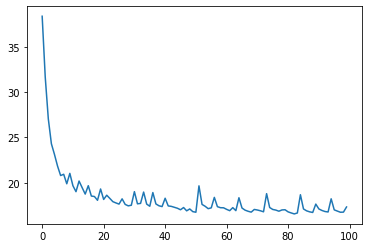

In [37]:
plt.plot(history.history['loss'])

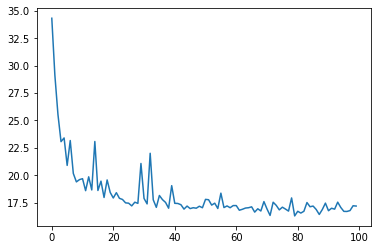

In [38]:
plt.plot(history.history['val_loss'])